## Building a GPT

Companion notebook to the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

In [70]:
import torch
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [71]:
sentences = [] 
with open("output_data_50.txt","r") as f:
    sentences = f.readlines()
sentences[:10]

text = "".join(sentences[:10000])

In [72]:
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [73]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?^_abcdefghijklmnopqrstuvwxyz
41


In [74]:
text[:100]

'paulina:true, too true, my lord:if, one by one_eno yb eno ,fi:drol ym ,eurt oot ,eurt:aniluap^\nr he '

In [75]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[22, 23, 23, 1, 34, 22, 19, 32, 19]
hii there


In [76]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([993982]) torch.int64
tensor([30, 15, 35, 26, 23, 28, 15, 10, 34, 32, 35, 19,  6,  1, 34, 29, 29,  1,
        34, 32, 35, 19,  6,  1, 27, 39,  1, 26, 29, 32, 18, 10, 23, 20,  6,  1,
        29, 28, 19,  1, 16, 39,  1, 29, 28, 19, 14, 19, 28, 29,  1, 39, 16,  1,
        19, 28, 29,  1,  6, 20, 23, 10, 18, 32, 29, 26,  1, 39, 27,  1,  6, 19,
        35, 32, 34,  1, 29, 29, 34,  1,  6, 19, 35, 32, 34, 10, 15, 28, 23, 26,
        35, 15, 30, 13,  0, 32,  1, 22, 19,  1, 27, 15, 25, 19,  1, 22, 23, 33,
         1, 37, 15, 39, 35, 28, 18, 19, 32,  1, 34, 22, 19,  1, 17, 29, 26, 29,
        35, 32,  1, 29, 20,  1, 22, 23, 33,  1, 35, 33, 35, 15, 26,  1, 21, 15,
        14, 15, 21,  1, 26, 15, 35, 33, 35,  1, 33, 23, 22,  1, 20, 29,  1, 32,
        35, 29, 26, 29, 17,  1, 19, 22, 34,  1, 32, 19, 18, 28, 35, 39, 15, 37,
         1, 33, 23, 22,  1, 19, 25, 15, 27,  1, 19, 22,  1, 32, 13,  0, 33, 15,
        21, 19, 33,  6,  1, 15, 28, 18,  1, 23, 28,  1, 34, 22, 19,  1, 19, 28,
       

In [77]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [78]:
block_size = 8
train_data[:block_size+1]

tensor([30, 15, 35, 26, 23, 28, 15, 10, 34])

In [79]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([30]) the target: 15
when input is tensor([30, 15]) the target: 35
when input is tensor([30, 15, 35]) the target: 26
when input is tensor([30, 15, 35, 26]) the target: 23
when input is tensor([30, 15, 35, 26, 23]) the target: 28
when input is tensor([30, 15, 35, 26, 23, 28]) the target: 15
when input is tensor([30, 15, 35, 26, 23, 28, 15]) the target: 10
when input is tensor([30, 15, 35, 26, 23, 28, 15, 10]) the target: 34


In [80]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[ 1,  6, 34, 33, 19, 24,  1, 18],
        [32, 16,  1, 32, 23, 19, 22, 34],
        [23, 29, 21,  1, 27, 15,  1, 23],
        [39,  1, 18, 19, 32, 18, 28, 35]])
targets:
torch.Size([4, 8])
tensor([[ 6, 34, 33, 19, 24,  1, 18, 19],
        [16,  1, 32, 23, 19, 22, 34,  1],
        [29, 21,  1, 27, 15,  1, 23,  1],
        [ 1, 18, 19, 32, 18, 28, 35, 22]])
----
when input is [1] the target: 6
when input is [1, 6] the target: 34
when input is [1, 6, 34] the target: 33
when input is [1, 6, 34, 33] the target: 19
when input is [1, 6, 34, 33, 19] the target: 24
when input is [1, 6, 34, 33, 19, 24] the target: 1
when input is [1, 6, 34, 33, 19, 24, 1] the target: 18
when input is [1, 6, 34, 33, 19, 24, 1, 18] the target: 19
when input is [32] the target: 16
when input is [32, 16] the target: 1
when input is [32, 16, 1] the target: 32
when input is [32, 16, 1, 32] the target: 23
when input is [32, 16, 1, 32, 23] the target: 19
when input is [32, 16, 1, 32, 2

In [81]:
print(xb) # our input to the transformer

tensor([[ 1,  6, 34, 33, 19, 24,  1, 18],
        [32, 16,  1, 32, 23, 19, 22, 34],
        [23, 29, 21,  1, 27, 15,  1, 23],
        [39,  1, 18, 19, 32, 18, 28, 35]])


In [82]:
class LayerNorm1d: # (used to be BatchNorm1d)

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        # calculate the forward pass
        xmean = x.mean(1, keepdim=True) # batch mean
        xvar = x.var(1, keepdim=True) # batch variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [83]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [84]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-9.5367e-09), tensor(1.0000))

### Full finished code, for reference
Based on Karpathy's code just adapted for the string reversa 

In [100]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 30000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

sentences = [] 
with open("output_data_50.txt","r") as f:
    sentences = f.readlines()

text = "".join(sentences[:50000])

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

0.810537 M parameters
step 0: train loss 3.8741, val loss 3.8729
step 500: train loss 2.3790, val loss 2.3867
step 1000: train loss 2.0862, val loss 2.0856
step 1500: train loss 1.8360, val loss 1.8394
step 2000: train loss 1.7242, val loss 1.7379
step 2500: train loss 1.6638, val loss 1.6826
step 3000: train loss 1.6149, val loss 1.6261
step 3500: train loss 1.5967, val loss 1.6194
step 4000: train loss 1.5558, val loss 1.5727
step 4500: train loss 1.5413, val loss 1.5584
step 5000: train loss 1.5160, val loss 1.5304
step 5500: train loss 1.5074, val loss 1.5272
step 6000: train loss 1.4936, val loss 1.5087
step 6500: train loss 1.4913, val loss 1.4957
step 7000: train loss 1.4708, val loss 1.4808
step 7500: train loss 1.4649, val loss 1.4694
step 8000: train loss 1.4456, val loss 1.4662
step 8500: train loss 1.4575, val loss 1.4556
step 9000: train loss 1.4283, val loss 1.4439
step 9500: train loss 1.4094, val loss 1.4311
step 10000: train loss 1.4192, val loss 1.4341
step 10500: tra

In [101]:
encode("this is a test_")

[34, 22, 23, 33, 1, 23, 33, 1, 15, 1, 34, 19, 33, 34, 14]

In [102]:
# generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)


context = torch.tensor(encode("this is a test_"), dtype = torch.long , device = device).view(1,-1)
print(context)
print(decode(m.generate(context, max_new_tokens=15)[0].tolist()))


tensor([[34, 22, 23, 33,  1, 23, 33,  1, 15,  1, 34, 19, 33, 34, 14]],
       device='cuda:0')
this is a test_tset a si siht 


In [103]:
import os
out_dir = "./checkpoints/"
checkpoint = {
                    'model': m.state_dict(),
                    'optimizer': optimizer.state_dict()
                }
print(f"saving checkpoint to {out_dir}")
torch.save(checkpoint, os.path.join(out_dir, 'string_reverse_v1.pt'))

saving checkpoint to ./checkpoints/


In [104]:
torch.save(m , os.path.join(out_dir, 'string_reverse_v1_model.pth'))

In [105]:
%store -r data_df

In [106]:
data_df.head()

,size,string,context,expected,generations,Rouge_scores
0,10,go?ratcl_lctar?og^\n,go?ratcl_,lctar?og^,lctarbgni,4
1,10,pedient du_ud tneidep^\n,pedient du_,ud tneidep^,ud tneidebi,2
2,10,"haste, an_na ,etsah ^\n","haste, an_","na ,etsah ^","na ,etsah h",1
3,10,y's answer_rewsna s'y^\n,y's answer_,rewsna s'y^,rewsna s'ye,1
4,10,es beheld!_!dleheb se^\n,es beheld!_,!dleheb se^,!dleb sevav,5


In [107]:
def generate(text):
    context = torch.tensor(encode(text), dtype = torch.long , device = device).view(1,-1)
    generations =  decode(m.generate(context, max_new_tokens=len(text) + 10)[0].tolist()).split("_")[1]
    index = generations.find('^')
    if index == -1:
        print("EOS did not happen")
    index = len(text)
    return generations[:index]

In [108]:
data_df["generations"] = data_df["context"].progress_apply(lambda x : generate(x))

  2%|▏         | 2/100 [00:00<00:05, 16.46it/s]

EOS did not happen
EOS did not happen


  4%|▍         | 4/100 [00:00<00:10,  9.60it/s]

EOS did not happen
EOS did not happen


  7%|▋         | 7/100 [00:00<00:11,  8.32it/s]

EOS did not happen
EOS did not happen


  9%|▉         | 9/100 [00:01<00:11,  7.90it/s]

EOS did not happen
EOS did not happen


 11%|█         | 11/100 [00:01<00:11,  7.51it/s]

EOS did not happen
EOS did not happen


 13%|█▎        | 13/100 [00:01<00:14,  6.08it/s]

EOS did not happen
EOS did not happen


 14%|█▍        | 14/100 [00:01<00:15,  5.71it/s]

EOS did not happen


 16%|█▌        | 16/100 [00:02<00:15,  5.36it/s]

EOS did not happen
EOS did not happen


 18%|█▊        | 18/100 [00:02<00:15,  5.22it/s]

EOS did not happen
EOS did not happen


 19%|█▉        | 19/100 [00:02<00:15,  5.14it/s]

EOS did not happen


 21%|██        | 21/100 [00:03<00:15,  5.08it/s]

EOS did not happen
EOS did not happen


 22%|██▏       | 22/100 [00:03<00:16,  4.63it/s]

EOS did not happen


 23%|██▎       | 23/100 [00:03<00:17,  4.38it/s]

EOS did not happen


 24%|██▍       | 24/100 [00:04<00:18,  4.18it/s]

EOS did not happen


 25%|██▌       | 25/100 [00:04<00:18,  4.15it/s]

EOS did not happen


 26%|██▌       | 26/100 [00:04<00:18,  4.06it/s]

EOS did not happen


 27%|██▋       | 27/100 [00:04<00:18,  3.98it/s]

EOS did not happen


 28%|██▊       | 28/100 [00:05<00:18,  3.89it/s]

EOS did not happen


 29%|██▉       | 29/100 [00:05<00:18,  3.90it/s]

EOS did not happen


 30%|███       | 30/100 [00:05<00:18,  3.89it/s]

EOS did not happen


 31%|███       | 31/100 [00:05<00:17,  3.93it/s]

EOS did not happen


 33%|███▎      | 33/100 [00:06<00:19,  3.45it/s]

EOS did not happen


 34%|███▍      | 34/100 [00:06<00:19,  3.35it/s]

EOS did not happen


 63%|██████▎   | 63/100 [00:18<00:17,  2.14it/s]

EOS did not happen


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


In [109]:
data_df.head()

,size,string,context,expected,generations,Rouge_scores
0,10,go?ratcl_lctar?og^\n,go?ratcl_,lctar?og^,"lctar,og",4
1,10,pedient du_ud tneidep^\n,pedient du_,ud tneidep^,ud tneidepe,2
2,10,"haste, an_na ,etsah ^\n","haste, an_","na ,etsah ^","na ,etsah t",1
3,10,y's answer_rewsna s'y^\n,y's answer_,rewsna s'y^,rewsna s'yo,1
4,10,es beheld!_!dleheb se^\n,es beheld!_,!dleheb se^,!dleheb sem,5


In [110]:
from Levenshtein import distance as levenshtein_distance

In [111]:
levenshtein_distance("this is an amazing sentence" , "this is a okay sentence")

7

In [112]:
def score(str1, str2): 
    scoring = Rouge()
    if len(str1) == 0 or len(str2) == 0:
        return max(len(str1),len(str2))
    scores= levenshtein_distance(str1, str2)
    return scores
data_df['Rouge_scores'] = data_df.apply(lambda x : score(x['generations'],x['expected']), axis = 1)

In [113]:
char_length = []
distance=[] 
error = []
for name , group in data_df.groupby("size"): 
    char_length.append(name)
    distance.append(np.mean(group['Rouge_scores']))
    error.append(np.std(group['Rouge_scores'])/np.sqrt(len(group)))

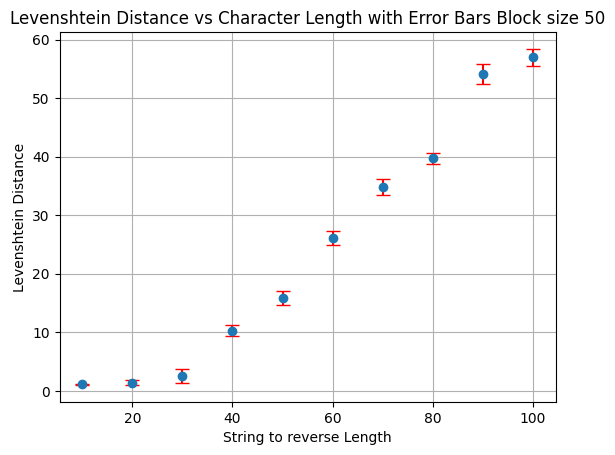

In [114]:
import matplotlib.pyplot as plt

# Assuming your lists look something like this:
# char_length = [list of character lengths]
# distance = [list of distances]
# error = [list of errors]

plt.errorbar(char_length, distance, yerr=error, fmt='o', ecolor='red', capsize=5)
plt.xlabel('String to reverse Length')
plt.ylabel('Levenshtein Distance')
plt.title('Levenshtein Distance vs Character Length with Error Bars Block size 50')
plt.grid(True)
plt.show()